In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import random

In [52]:
%load_ext autoreload
%autoreload 2
from base import utils, datahandler, prediction_models, evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Define the directory paths
challenge_data_dir = Path('dataset/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

In [54]:
# get all labels in the dataframes
keys_list = list(split_dataframes.keys())
random.Random(69).shuffle(keys_list) # shuffle, but with a seed for reproducability
split_idx = int(len(keys_list) * 0.8)
train_keys = keys_list[:split_idx]
train_labels_EW = []
train_labels_NS = []
val_keys = keys_list[split_idx:]
val_labels_EW = []
val_labels_NS = []
for key in train_keys:
    train_labels_EW += list(split_dataframes[key]['EW'].unique())
    train_labels_NS += list(split_dataframes[key]['NS'].unique())
for key in val_keys:
    val_labels_EW += list(split_dataframes[key]['EW'].unique())
    val_labels_NS += list(split_dataframes[key]['NS'].unique())
train_labels_EW = list(dict.fromkeys(train_labels_EW))
train_labels_NS = list(dict.fromkeys(train_labels_NS))
val_labels_EW = list(dict.fromkeys(val_labels_EW))
val_labels_NS = list(dict.fromkeys(val_labels_NS))
print(train_labels_EW)
print(val_labels_EW)
print(train_labels_NS)
print(val_labels_NS)


['SS-CK', 'SS-HK', 'SS-EK']
['SS-CK', 'SS-HK']
['SS-NK', 'IK-CK', 'SS-CK', 'SS-HK', 'IK-HK']
['SS-NK', 'IK-CK', 'SS-HK']


In [297]:
ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, train_val_split=0.85, stride=1, input_steps=8, seed=69)

Creating dataset from 15 train and 3 val objects
Creating datasets with labels ['EW', 'EW_Node', 'EW_Type', 'NS', 'NS_Node', 'NS_Type']
Created datasets with seed 69


In [271]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW'], shuffle=True)
train_NS, val_NS = ds_gen.get_datasets(128, label_features=['NS'], shuffle=True)
#dense_model_ew = prediction_models.Dense_NN(train_EW, dense_layers=[512,256,32], l2_reg=0.0001, mixed_dropout=0.2)
#dense_model_ns = prediction_models.Dense_NN(train_EW, dense_layers=[512,256,32], l2_reg=0.0001, mixed_dropout=0.2)
dense_model_ew = prediction_models.Dense_NN(train_EW, dense_layers=[512,512], l2_reg=0.00, mixed_dropout=0.0, seed=0)
dense_model_ns = prediction_models.Dense_NN(train_NS, dense_layers=[512,512], l2_reg=0.00, mixed_dropout=0.0, seed=0)
print("Training model #1")
hist_ew = dense_model_ew.fit(train_EW, val_ds=val_EW, epochs=40, verbose=0, plot_hist=False) # TODO: somehow this sometimes has save_best_only enabled?? even though its only enabled in 2nd fit? ... do inherited models somehow modify the mother class?!?
print("Training model #2")
hist_ns = dense_model_ns.fit(train_NS, val_ds=val_NS, epochs=40, verbose=0, plot_hist=False)
print("EW results:")
dense_model_ew.model.evaluate(train_EW)
dense_model_ew.model.evaluate(val_EW)
print("NS results:")
dense_model_ns.model.evaluate(train_NS)
dense_model_ns.model.evaluate(val_NS)

Training model #1
Training model #2
EW results:
51/51 [==============================] - 0s 3ms/step - loss: 11.8038 - accuracy: 0.5483
NS results:
51/51 [==============================] - 0s 3ms/step - loss: 26.7497 - accuracy: 0.3017


[26.749740600585938, 0.3017188310623169]

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 8, 16)]              0         []                            
                                                                                                  
 flatten_42 (Flatten)        (None, 128)                  0         ['input_43[0][0]']            
                                                                                                  
 dense_91 (Dense)            (None, 512)                  66048     ['flatten_42[0][0]']          
                                                                                                  
 dropout_29 (Dropout)        (None, 512)                  0         ['dense_91[0][0]']            
                                                                                           

c:\Code\ARCLab Challenge\splid-challenge\base\prediction_models.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


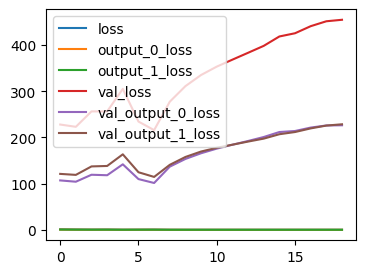

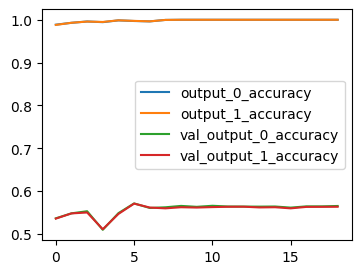

In [315]:
train_combined, val_combined = ds_gen.get_datasets(64, label_features=['EW', 'NS'], shuffle=True)
dense_combined_model = prediction_models.Dense_NN(train_combined, dense_layers=[512,512,64,32], l2_reg=0.0, mixed_dropout=0.15, lr_scheduler=[10000,0.8], seed=0)
dense_combined_model.summary()
hist = dense_combined_model.fit(train_combined, val_ds=val_combined, target_metric='loss', epochs=20, verbose=2, plot_hist=False, save_best_only=True)
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_combined_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [316]:
dense_combined_model.evaluate(train_combined)

510/510 [==============================] - 2s 3ms/step - loss: 9.3367e-06 - output_0_loss: 4.0657e-06 - output_1_loss: 5.2710e-06 - output_0_accuracy: 1.0000 - output_1_accuracy: 1.0000


[9.3367279987433e-06, 4.065741450176574e-06, 5.270982910587918e-06, 1.0, 1.0]

In [ ]:
# TODO: find out if we can directly train for precision/challenge metrics
# TODO: maybe it makes sense to look at values before and after the node? Given that we are trying to detect changes...
# TODO: check if train_NS even contains all the labels in val_NS... in general, train should contain all labels
# TODO: Make sure labelencoder gets saved

In [284]:
def prepare_submission_df(ds, model, model_output_features, label_decoders):
    '''Prepare dataframes for submission based on models predictions. The output_labels need to be in the same order as they were when creating the dataset!'''
    assert(len(model_output_features) == len(label_decoders))
    inputs = np.concatenate([element for element in ds.map(lambda *args: args[0]).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda *args: args[-1]).as_numpy_iterator()])
    
    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)

    preds = model.predict(inputs)
    for ft_idx, feature in enumerate(model_output_features):
        labels = np.concatenate([element for element in ds.map(lambda *args: args[1+ft_idx]).as_numpy_iterator()])
        labels_decoded = label_decoders[ft_idx].inverse_transform(labels)
        preds_argmax = np.argmax(preds[ft_idx], axis=1) if len(model_output_features)>1 else np.argmax(preds, axis=1)
        preds_decoded = label_decoders[ft_idx].inverse_transform(preds_argmax)
        df[f'{feature}'] = labels_decoded
        df[f'Predicted_{feature}'] = preds_decoded
    return df


In [285]:
ground_truth = pd.read_csv(challenge_data_dir / 'train_labels.csv')
ground_truth_train = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.train_keys))].copy()
ground_truth_val = ground_truth[ground_truth['ObjectID'].isin(map(int, ds_gen.val_keys))].copy()

In [324]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_train=prepare_submission_df(ds=train_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'], label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder])
smoothed_df_train = utils.smooth_predictions(df_train, past_steps=0, fut_steps=0)
train_results = utils.convert_classifier_output(smoothed_df_train).sort_values(['ObjectID']).reset_index(drop=True)
print(len(train_results))
print(train_results.sort_values(['ObjectID', 'TimeIndex', 'Direction']).head(50))
print(len(ground_truth_train))
print(ground_truth_train.sort_values(['ObjectID', 'TimeIndex', 'Direction']).head(50))
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_train, train_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the train set: {precision:.2f}')
print(f'Recall for the train set: {recall:.2f}')
print(f'F2 for the train set: {f2:.2f}')
print(f'RMSE for the train set: {rmse:.2f}')

# TODO: we are not predicting a single change with the model right now... leading to ridiculous 0.8 precision
# TODO: predict on val with simly ss node and predict engine type... might give quite high precision?

1019/1019 [==============================] - 2s 2ms/step


Smoothing: 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


30
    ObjectID  TimeIndex Direction Node Type
0          1          0        EW   SS   CK
1          1          0        NS   SS   CK
2          2          0        EW   SS   HK
3          2          0        NS   SS   HK
4          3          0        EW   SS   CK
5          3          0        NS   SS   CK
6          4          0        EW   SS   HK
7          4          0        NS   SS   HK
8          5          0        EW   SS   EK
9          5          0        NS   SS   EK
10         6          0        EW   SS   CK
11         6          0        NS   SS   CK
12         7          0        EW   SS   CK
13         7          0        NS   SS   CK
15         8          0        EW   SS   CK
14         8          0        NS   SS   CK
16         9          0        EW   SS   CK
17         9          0        NS   SS   CK
18        11          0        EW   SS   HK
19        11          0        NS   SS   HK
20        13          0        EW   SS   HK
21        13          0      

In [306]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW', 'NS'], shuffle=False, keep_identifier=True)
df_val=prepare_submission_df(ds=val_EW, model=dense_combined_model.model, model_output_features=['EW', 'NS'], label_decoders=[ds_gen.combined_label_encoder, ds_gen.combined_label_encoder])
smoothed_df_val = utils.smooth_predictions(df_val, past_steps=2, fut_steps=5)
val_results = utils.convert_classifier_output(smoothed_df_val).sort_values(['ObjectID']).reset_index(drop=True)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_val, val_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the val set: {precision:.2f}')
print(f'Recall for the val set: {recall:.2f}')
print(f'F2 for the val set: {f2:.2f}')
print(f'RMSE for the val set: {rmse:.2f}')


204/204 [==============================] - 0s 2ms/step


Smoothing: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]

Precision for the val set: 0.01
Recall for the val set: 0.25
F2 for the val set: 0.03
RMSE for the val set: 0.00


In [288]:
train_EW, val_EW = ds_gen.get_datasets(128, label_features=['EW'], shuffle=False, keep_identifier=True)
train_NS, val_NS = ds_gen.get_datasets(128, label_features=['NS'], shuffle=False, keep_identifier=True)
df_EW = prepare_submission_df(ds=train_EW, model=dense_model_ew.model, model_output_features=['EW'], label_decoders=[ds_gen.combined_label_encoder])
df_NS = prepare_submission_df(ds=train_NS, model=dense_model_ns.model, model_output_features=['NS'], label_decoders=[ds_gen.combined_label_encoder])
combined_df = df_EW
combined_df['NS'] = df_NS['NS']
combined_df['Predicted_NS'] = df_NS['Predicted_NS']
smoothed_df_val = utils.smooth_predictions(combined_df)
train_results = utils.convert_classifier_output(smoothed_df_val).sort_values(['ObjectID']).reset_index(drop=True)
evaluator = evaluation.NodeDetectionEvaluator(ground_truth_train, train_results)
precision, recall, f2, rmse = evaluator.score()
print(f'Precision for the train set: {precision:.2f}')
print(f'Recall for the train set: {recall:.2f}')
print(f'F2 for the train set: {f2:.2f}')
print(f'RMSE for the train set: {rmse:.2f}')

1019/1019 [==============================] - 2s 2ms/step


Smoothing: 100%|██████████| 15/15 [00:16<00:00,  1.12s/it]


Precision for the train set: 0.65
Recall for the train set: 0.65
F2 for the train set: 0.65
RMSE for the train set: 0.58
